# Effect of weight renormalization on activity patterns

In this experiment we show the influence of weight renormalization on the structure of activations in different layers. 

Over the course of training the weights in a neural network usually get larger. For `tanh` activated neurons as an example this means that on average the preactivations will be larger in magnitude and therefore the output of the neurons be close to either -1 or 1. 

It was argued in the opposing paper that in general double-sided saturating nonlinearities like `tanh` yield a compression phase as neural activations enter the saturation regime. For `relu`, the process of ever growing weights yields bigger activations over time for the positive side of the activation spectrum. It is argued, that as `relu` is not bounded for positive preactivations, this does not lead to compression in later stages of the training.

## Experiments with max_weight_norm=0.8

Here, we are picking up on these ideas by introducing rescaling of the weights after each epoch, such that the norm of every neuron's weight vector does not exceed a specific threshold. We observe activation patterns that appear under these constraint during training and interpret these with respect to the phenomenon of "compression" in the infoplane plot.

In [1]:
import sys
sys.path.append('../..')
from deep_bottleneck.eval_tools.experiment_loader import ExperimentLoader
from deep_bottleneck.eval_tools.utils import format_config, find_differing_config_keys
import matplotlib.pyplot as plt
from io import BytesIO

import pandas as pd
import numpy as np

In [2]:
loader = ExperimentLoader()

In [3]:
experiment_ids = [599, 600, 601, 602]
experiments = loader.find_by_ids(experiment_ids)
differing_config_keys = find_differing_config_keys(experiments)

We first look at the informationplane plot for 4 different experiments. We varied the activation function between `tanh` and `relu` as well as fixing the maximum magnitude of the weight vector per neuron to 0.8 (`max_norm_weights=0.8`) or leaving the weight magnitude unconstrained (`max_norm_weight=False`). The corresponding informationplane plots for one run are displayed below.

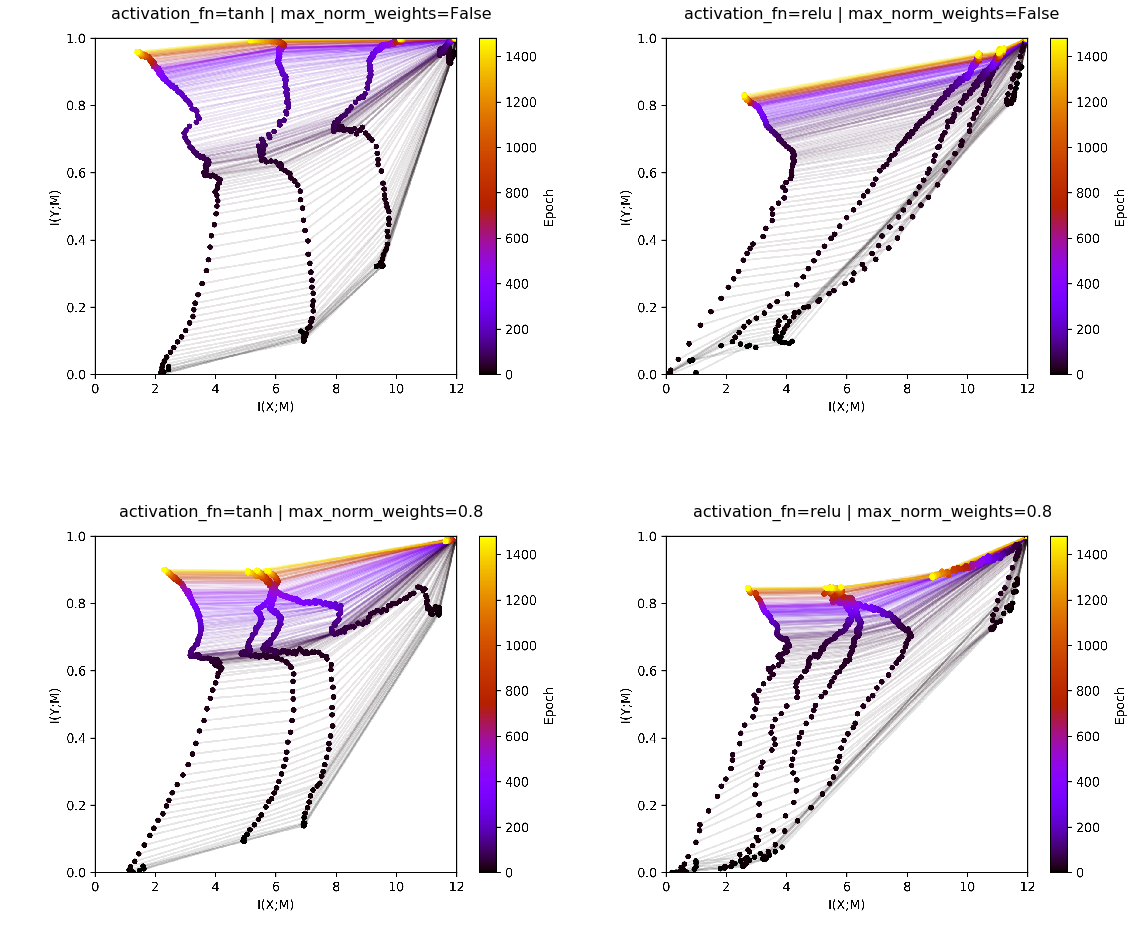

In [4]:
fig, ax = plt.subplots(2,2, figsize=(16, 14))
ax = ax.flat

for i, experiment in enumerate(experiments):
    img = plt.imread(BytesIO(experiment.artifacts['infoplane'].content))
    ax[i].axis('off')
    ax[i].imshow(img)
    ax[i].set_title(format_config(experiment.config, *differing_config_keys),
                    fontsize=16)
plt.tight_layout()    
plt.show()

With no weight regularzation, for `relu` we see a pattern in the infoplane as it has been reported before by the opposing paper. Except for the last layer, which always has a `softmax` activation function, no distict compression phase is visible. For `tanh`, the 5th layer starts to compress, while all previous layers do not show distinct compression. In a previously run experiment with several runs it was comfirmed that on average over several runs the earlier layers do show compression as well. Still, we keep in mind that the phenomenon is not as stable as it might be suggested by reports of Tishby et. al. Additionally, the prominent "dip" to the left after 60-100 epochs is missing interpretation by previous works of Tishby and the opposing paper. Also, it seems to be to consistent in some experimental settings as to be only a result of random fluctuations.

With weight normalization, several layers of `tanh` start to compress. Furthermore and noteably, with resticted weight norm, **`relu` compresses.** The layers of both `relu` and `tanh` do not reach information with the output as high as they did without constrained weights. Below we plot training and validation accuracies to confirm that the weight regularization does not come at a cost of a signitficant loss of accuracy. 

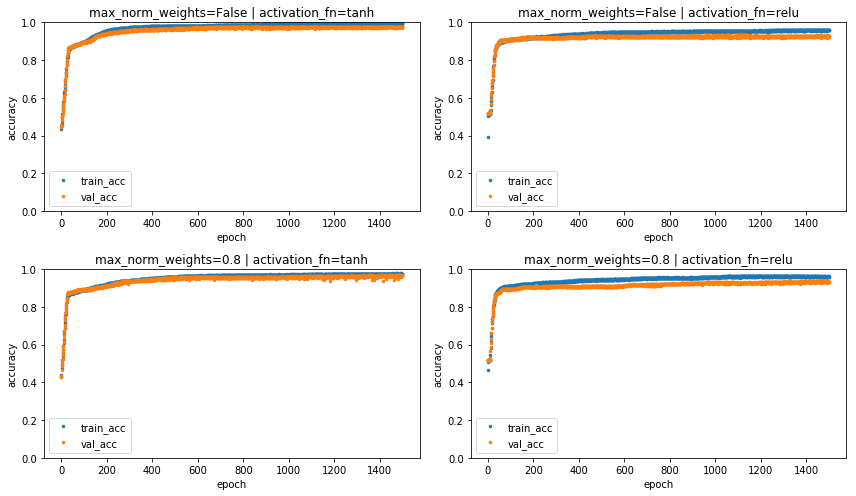

In [9]:
fig, ax = plt.subplots(2,2, figsize=(12, 7))
ax = ax.flat

for i, experiment in enumerate(experiments): 
    df = pd.DataFrame(data=np.array([experiment.metrics['training.accuracy'].values, experiment.metrics['validation.accuracy'].values]).T,
                  index=experiment.metrics['validation.accuracy'].index,
                  columns=['train_acc', 'val_acc'])

    df.plot(linestyle='', marker='.', markersize=5, ax=ax[i])
    ax[i].set_title(format_config(experiment.config, *differing_config_keys),
                    fontsize=12)
    ax[i].set_ylim([0,1])
    ax[i].set(xlabel='epoch', ylabel='accuracy')

plt.tight_layout()    
plt.show()

Mutual information with the input for deterministic networks is currently calculated as the entropy of the representation. The representation in this context is the (histogram of the) activation pattern resulting from display of all input samples to the network in a specific epoch. A process towards a lower entropy activity distribution is therefore termed "compression".

We now look at the average activations over epochs for each layer. Each column for the plots is a non-normalized histogram with 30 bins of the activations that were recorded during training and testing of the network. 

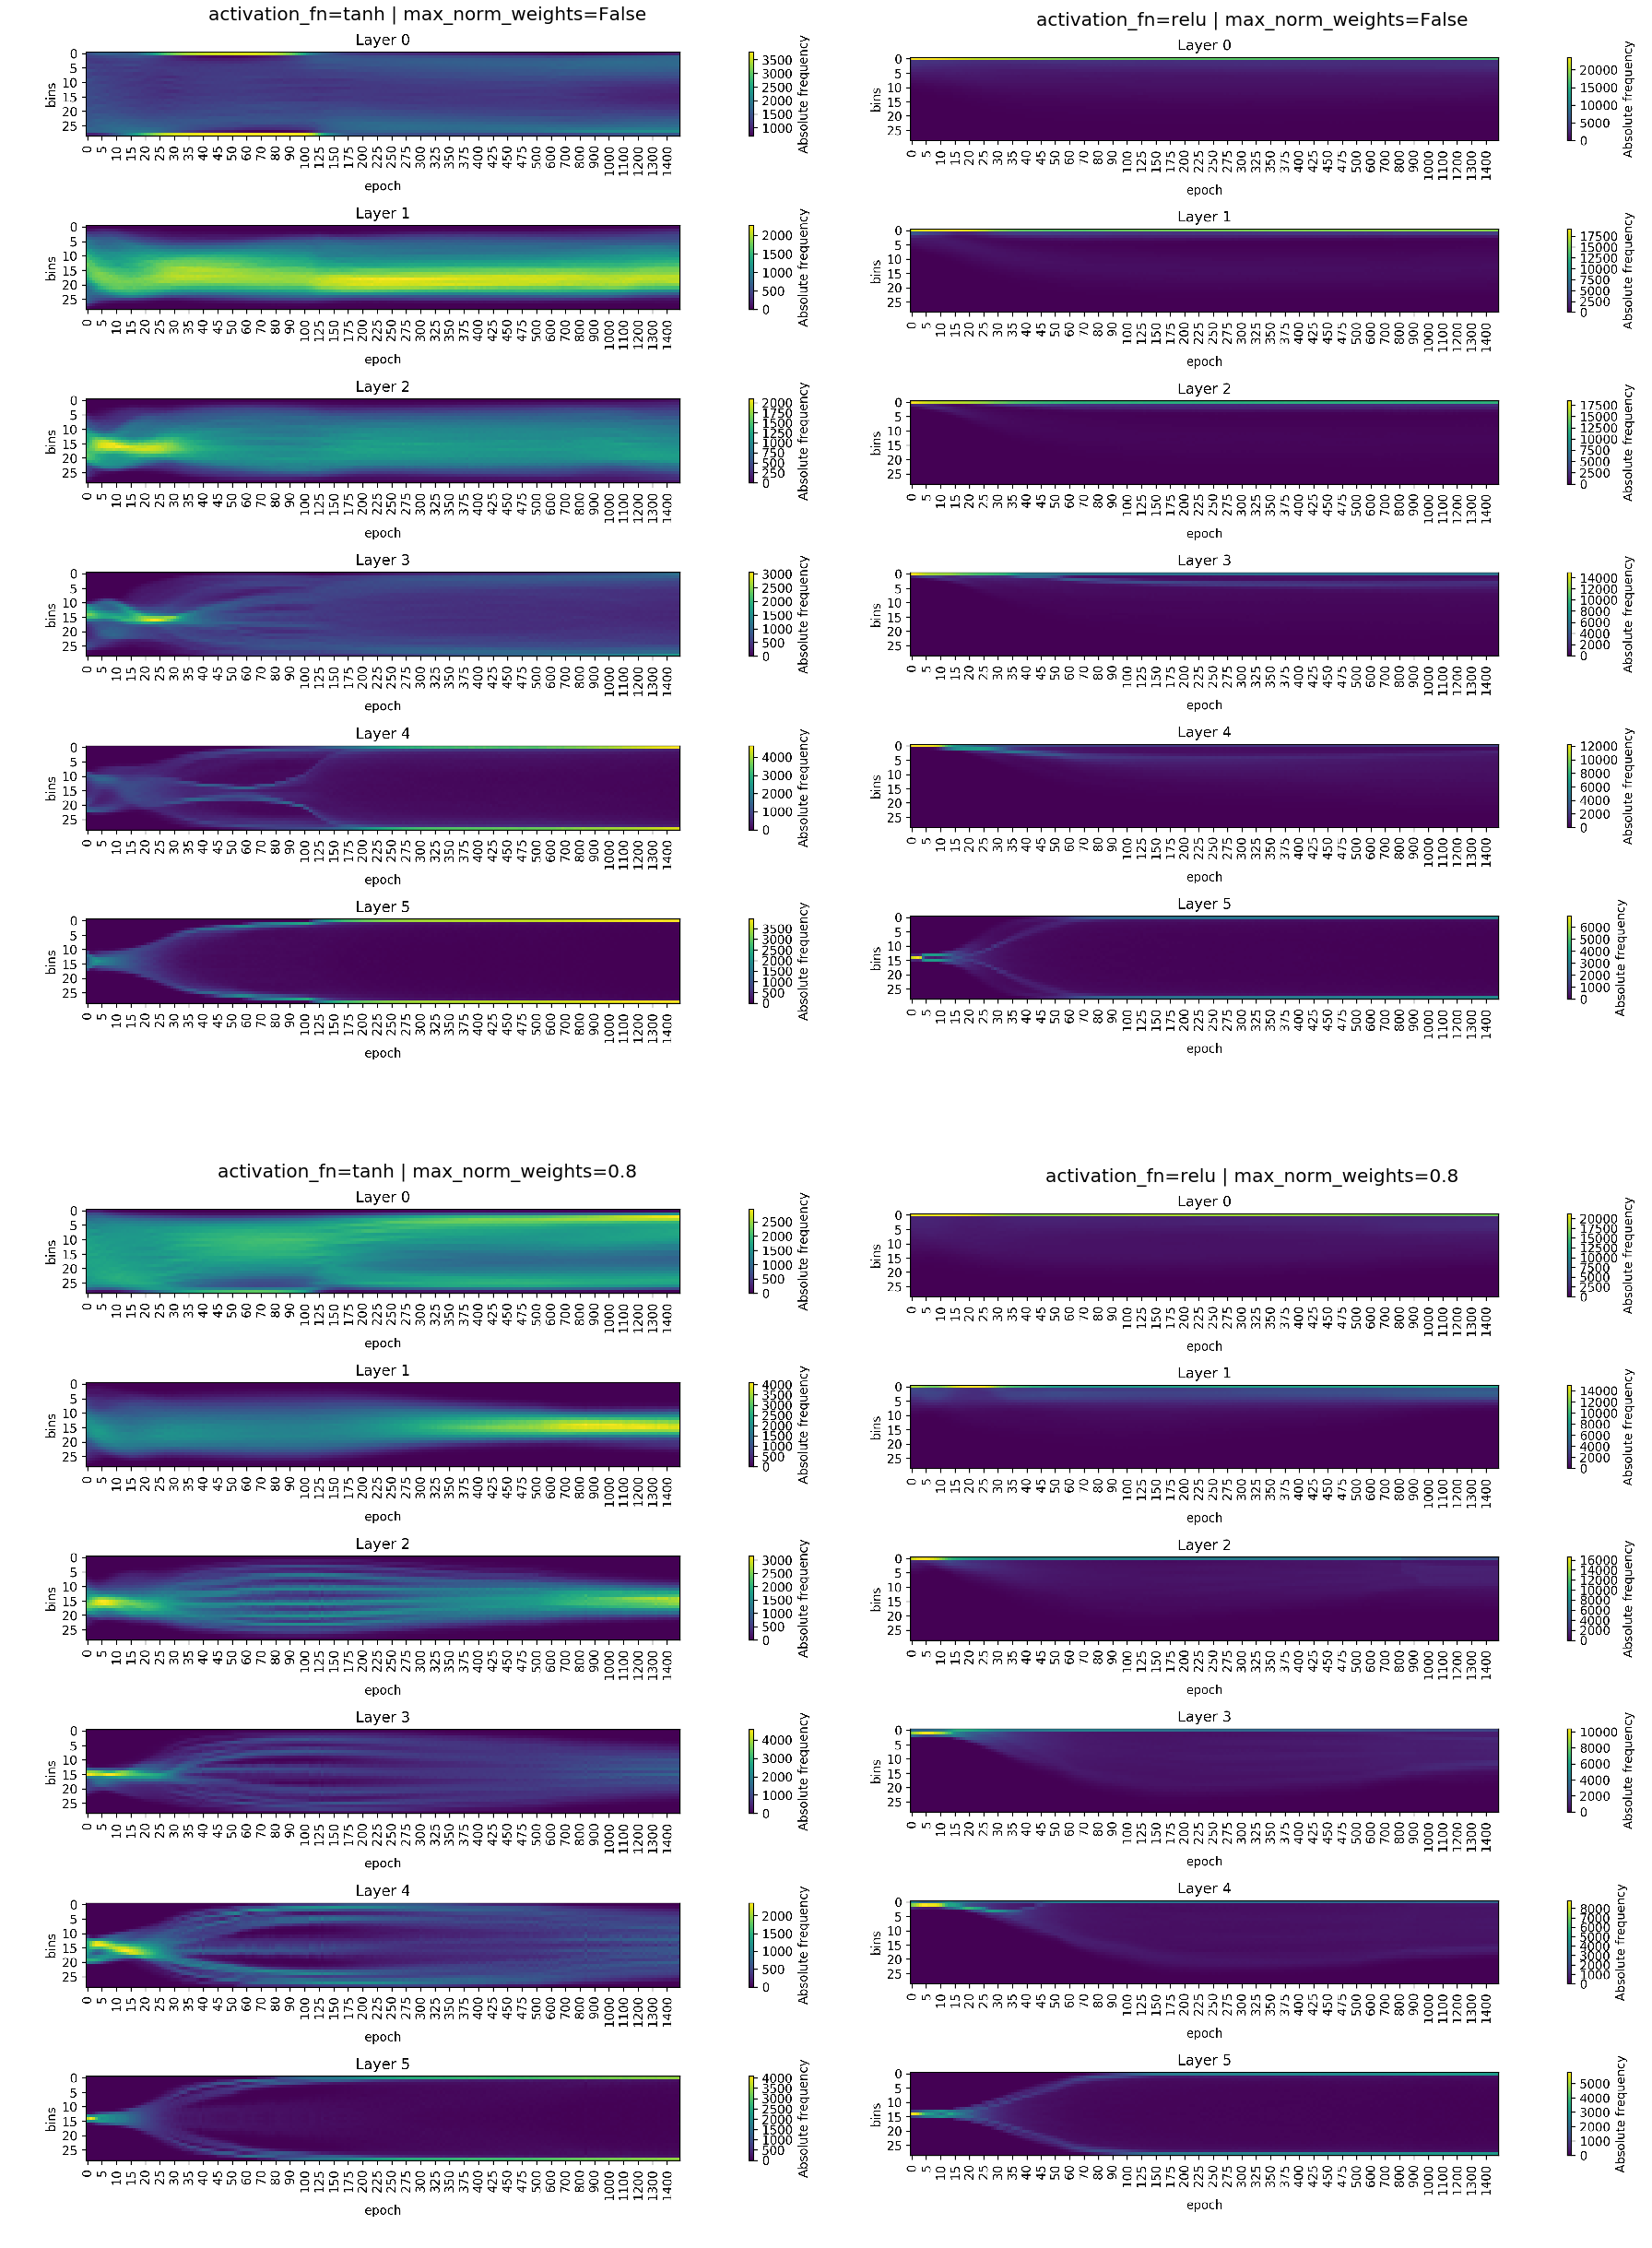

In [6]:
fig, ax = plt.subplots(2,2, figsize=(25, 35))
ax = ax.flat

for i, experiment in enumerate(experiments): 
    img = plt.imread(BytesIO(experiment.artifacts['activations'].content))
    ax[i].axis('off')
    ax[i].imshow(img)
    ax[i].set_title(format_config(experiment.config, *differing_config_keys),
                    fontsize=20)

plt.tight_layout()    
plt.show()

In the activation plots for `tanh` we can identify several very prominent peaks of activations, especially during epochs 30-120 for normal `tanh` and 30-250 for weight-restricted `tanh`. These activity patterns conincide with the early phase of compression in the `tanh` informationplane plots. Towards the end of training, higher layers saturate and have peaks at activations of -1 and 1 in the histograms. This phase also displays as compression in the informationplane plot.

With regards to `relu`, the unconstrained network exhibits a peak of activations at 0. In tendency, the remaining nonzero activations grow over the course of training and spread a broader range. This distribution has little structure (except for the prominent peak at 0) and congruent with this also does not show compression in the informationplane. The bias towards the entropy of the prominent peak at 0 due to the `relu` activation function will be discussed in more detail in another notebook. 

In the experiment with `relu`  and with constrained weight vector, the nonzero activations in the higher layers, especially in layer 3 and 4, show several relatively pronounced peaks. They do not seem to be very prominent, because there is still an big portion of all activations at 0. The pattern of several equidistant peaks of activation is similar to the one observed in weight constrained tanh plots. Again, this is a process towards a lower entropy distribution, which is reflected by the observed "compression" in the information plane.

## Experiment with max_weight_norm=0.4

In the following we present an example with `relu` and the norm of the weight vector for each layer restricted to 0.4
This is a significantly stronger regularization which this time will also have an effect on the performance of the network. 

In [12]:
relu04 = loader.find_by_id(603)
relu04.config

{'activation_fn': 'relu',
 'architecture': [10, 7, 5, 4, 3],
 'batch_size': 256,
 'calculate_mi_for': 'full_dataset',
 'callbacks': [],
 'dataset': 'datasets.harmonics',
 'discretization_range': 0.07,
 'epochs': 1500,
 'estimator': 'mi_estimator.binning',
 'learning_rate': 0.0004,
 'max_norm_weights': 0.4,
 'model': 'models.feedforward',
 'n_runs': 1,
 'optimizer': 'adam',
 'plotters': [['plotter.informationplane', []],
  ['plotter.snr', []],
  ['plotter.informationplane_movie', []],
  ['plotter.activations', []],
  ['plotter.activations_single_neuron', []]],
 'seed': 42}

In the infoplane plot below it can be seen that training is impaired for the choice of such strict weight regularization.

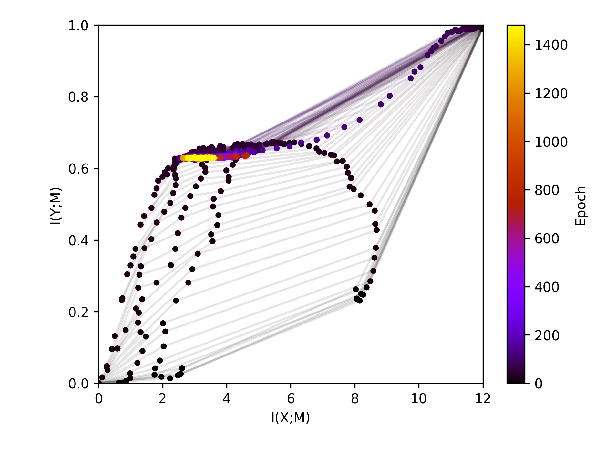

In [8]:
relu04.artifacts['infoplane'].show()

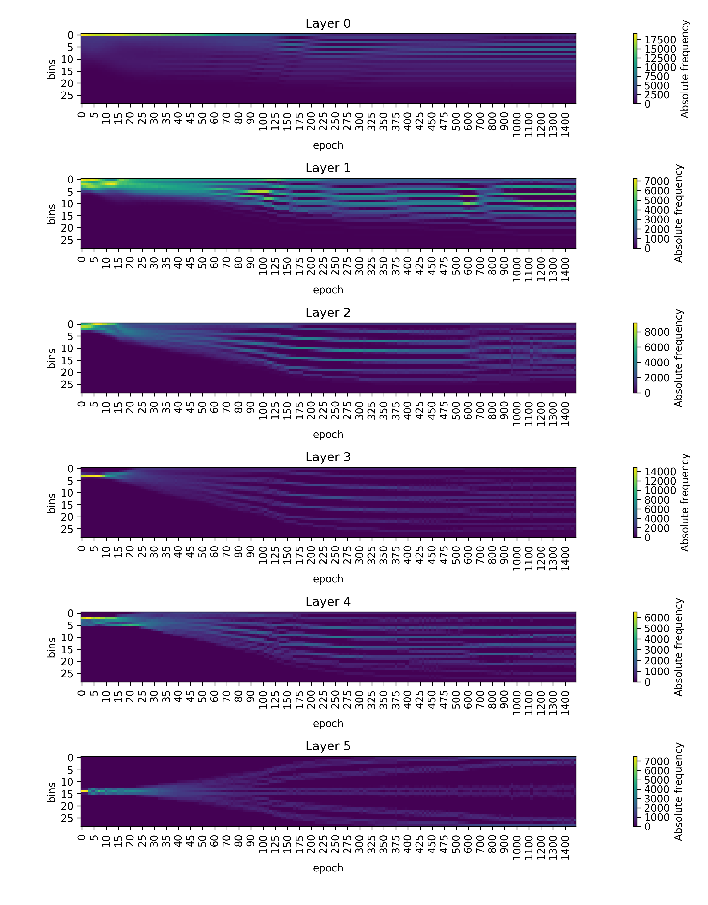

In [9]:
relu04.artifacts['activations'].show(figsize=(12,16))

The activation pattern of several peaks is even more pronounced with stronger restiction on the size of the weights. 

The performance of the network is worse than with higher weightnorm. But the training dynamics still look ok. The network learns the task up to a certain accurcy without overfitting.

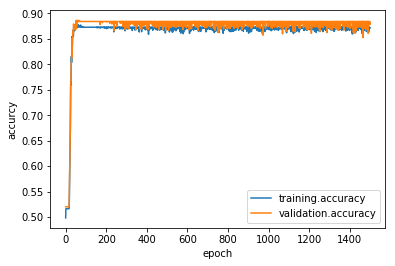

In [15]:
relu04.metrics['training.accuracy'].plot()
relu04.metrics['validation.accuracy'].plot()
plt.ylabel('accurcy')
plt.xlabel('epoch')
plt.legend()

## Supplementary material

Below we find plots indicating the development of means and standard deviation of the gradient, its signal to noise ratio as well as the norm of the weight vector for all layers over the course of training. Comparing plots for unconstrained vs. constrained weight vector, we can reassure ourselves that rescaling the weights worked as we expected.

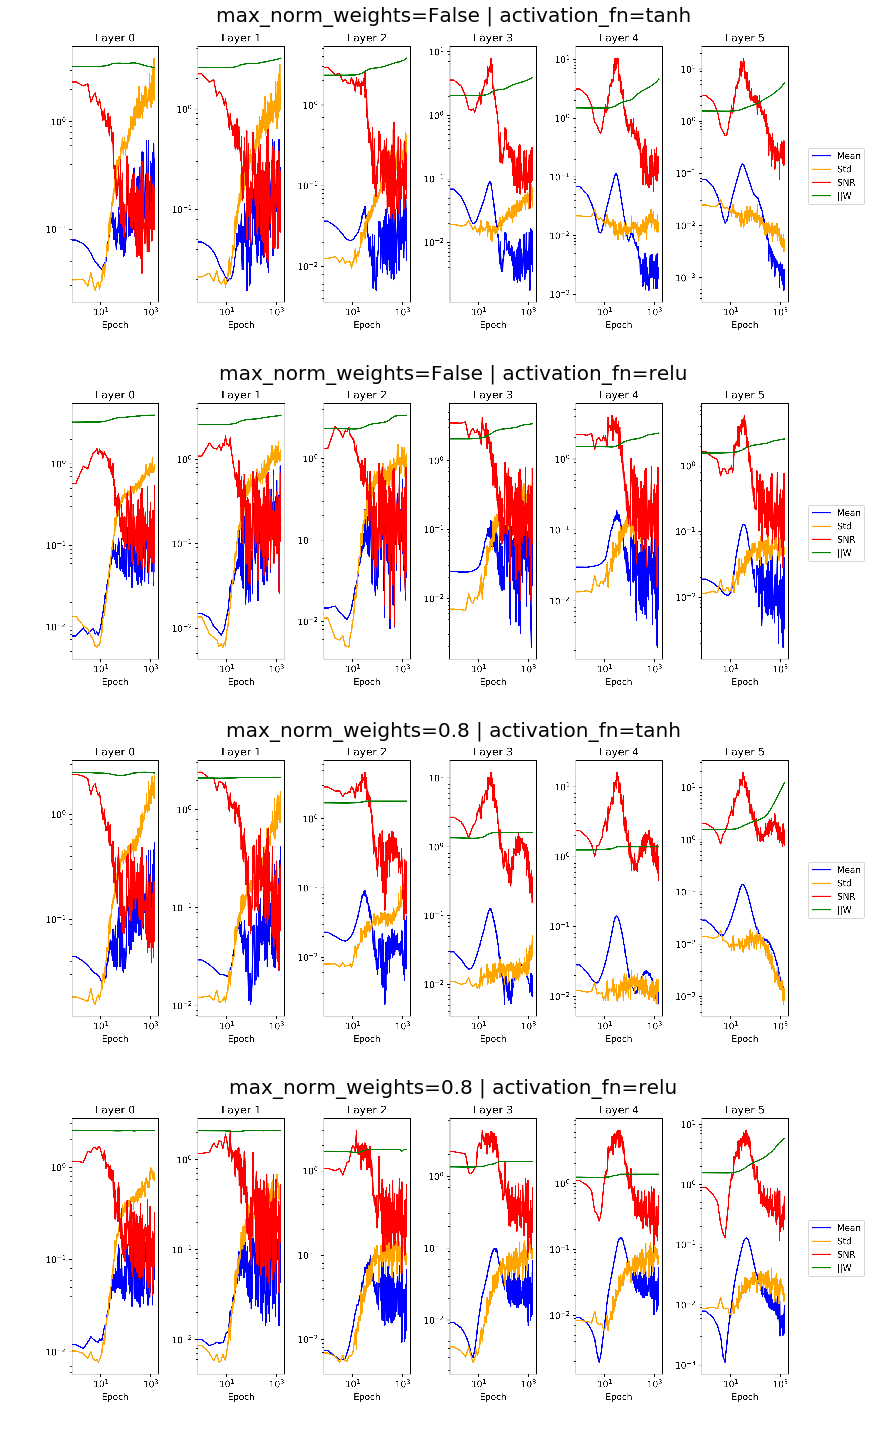

In [10]:
fig, ax = plt.subplots(4,1, figsize=(16, 20))
ax = ax.flat

for i, experiment in enumerate(experiments): 
    img = plt.imread(BytesIO(experiment.artifacts['snr'].content))
    ax[i].axis('off')
    ax[i].imshow(img)
    ax[i].set_title(format_config(experiment.config, *differing_config_keys),
                    fontsize=20)

plt.tight_layout()    
plt.show()

Below we find the configuration of all non-varied parameters that we used for the experiments above.

In [10]:
variable_config_dict = {k: '<var>' for k in differing_config_keys}
config = experiment.config
config.update(variable_config_dict)
config

{'activation_fn': '<var>',
 'architecture': [10, 7, 5, 4, 3],
 'batch_size': 256,
 'calculate_mi_for': 'full_dataset',
 'callbacks': [],
 'dataset': 'datasets.harmonics',
 'discretization_range': 0.07,
 'epochs': 1500,
 'estimator': 'mi_estimator.binning',
 'learning_rate': 0.0004,
 'max_norm_weights': '<var>',
 'model': 'models.feedforward',
 'n_runs': 1,
 'optimizer': 'adam',
 'plotters': [['plotter.informationplane', []],
  ['plotter.snr', []],
  ['plotter.informationplane_movie', []],
  ['plotter.activations', []],
  ['plotter.activations_single_neuron', []]],
 'seed': 42}